### Modeling Durham County Inspection Grades

Notebook by Temilola Famakinwa


**Overview**

In the last notebook inspection data was processed to create training and test data from Durham county inspection data, and stored as csv files.

In this notebook we will model the data using:
  * Support Vector Regression (SVR)
  * RanfomForest
  * XGBoost
  
The best model will be found by using RandomizedGridSearch and Bayes Optimization in conjunction with cross validation to determine best hyperparameters. We will evaluate whether Bayes Optimization or RandomizedGridSearch finds the best hyperparameters. This will be evaluated on the training data. After the best model is chosen, it will be run on the test data using the best hyper parameters.


In [1]:
# Install XGBoost and Bayes-Opt
!pip install xgboost
! pip install bayesian-optimization

In [2]:
# Import ML models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Import modeling modules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Import data analysis modules
import pandas as pd
import math
import numpy as np
import time

# Import datavizualization modules
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read training and test data csv files into the notebook.
y_test = pd.read_csv('/content/y_test.csv')
y_train = pd.read_csv('/content/y_train.csv')
X_test = pd.read_csv('/content/Xtest_scaled.csv')
X_train = pd.read_csv('/content/Xtrain_scaled.csv')

### **Cleaning Data**
Remove the indexes from the training and test dataframes.

In [4]:
# Check the head of each dataframe
print(y_test.head(2))
print(y_train.head(2))
print(X_train.head(2))
print(X_test.head(2))

   Unnamed: 0  score_sum
0        3990        0.0
1        9198       84.0
   Unnamed: 0  score_sum
0        1216        4.0
1         729        0.0
   Unnamed: 0         0         1         2         3         4         5  \
0           0  1.499727  1.494142 -0.541742 -0.148842 -0.960654  0.399955   
1           1 -0.663583 -0.669213  1.120964 -0.711377  1.193626  0.783354   

          6         7         8  ...       222       223      224       225  \
0  3.144452 -0.265092  1.869379  ... -0.133815 -0.159808 -0.10699 -0.159897   
1 -0.450645 -0.265092 -0.175174  ... -0.133815 -0.159808 -0.10699 -0.159897   

        226       227      228      229       230       231  
0 -0.121614 -0.355687 -0.11028 -0.13524 -0.137607 -0.128896  
1 -0.121614 -0.355687 -0.11028 -0.13524 -0.137607 -0.128896  

[2 rows x 233 columns]
   Unnamed: 0         0         1         2         3         4         5  \
0           0 -0.663583 -0.669213 -0.485187 -0.785369 -0.960654  0.349801   
1           1  1

In [5]:
# Remove Unnnamed: 0 column from every dataframe.
y_train = y_train.drop(['Unnamed: 0'], axis = 1)
y_test = y_test.drop(['Unnamed: 0'], axis = 1)
X_train = X_train.drop(['Unnamed: 0'], axis = 1)
X_test = X_test.drop(['Unnamed: 0'], axis = 1)

In [6]:
# Check the head of each dataframe again.
print(y_test.head(2))
print(y_train.head(2))
print(X_train.head(2))
print(X_test.head(2))

   score_sum
0        0.0
1       84.0
   score_sum
0        4.0
1        0.0
          0         1         2         3         4         5         6  \
0  1.499727  1.494142 -0.541742 -0.148842 -0.960654  0.399955  3.144452   
1 -0.663583 -0.669213  1.120964 -0.711377  1.193626  0.783354 -0.450645   

          7         8         9  ...       222       223      224       225  \
0 -0.265092  1.869379  1.618404  ... -0.133815 -0.159808 -0.10699 -0.159897   
1 -0.265092 -0.175174 -0.762451  ... -0.133815 -0.159808 -0.10699 -0.159897   

        226       227      228      229       230       231  
0 -0.121614 -0.355687 -0.11028 -0.13524 -0.137607 -0.128896  
1 -0.121614 -0.355687 -0.11028 -0.13524 -0.137607 -0.128896  

[2 rows x 232 columns]
          0         1         2         3         4         5         6  \
0 -0.663583 -0.669213 -0.485187 -0.785369 -0.960654  0.349801 -0.379845   
1  1.499727  1.494142 -1.107288 -0.344970 -0.960654 -1.621519 -0.387712   

          7         8 

Code used in the following section was adapted from a Youtube video " 8.6. Model Selection in Machine Learning with Python | Choosing the right Machine Learning model" https://www.youtube.com/watch?v=zU88wcLbBF8&t=396s. The collab notebook can be found here: https://colab.research.google.com/drive/1_-FIjBA96shDp3mTwbzMyx0uq6uU_ltL?usp=sharing#scrollTo=sHCGhgcErTI0

In [7]:
# Create list of models for RandomizedSearchCV
model_list = [SVR(), RandomForestRegressor(random_state=0), XGBRegressor(random_state=0)]

### **Hyperparameter Tuning by RandomizedSearchCV**

In [8]:
# Create dictionary of hyperparameters of each model family

model_hyperparameters = {
    'sv_reg' : {
        'kernel' : ['poly', 'rbf'],
        'epsilon' : [0.001, 0.1, 1],
        'C' : [1, 50,  100]
    },
    'rf_reg' : {
        'n_estimators' : [50, 100, 150],
        'max_features' : ['sqrt', 'log2'],
        'max_depth' : [3 , 6, 9],
        'max_leaf_nodes' : [3, 6, 9]
    },
    'xbg_reg' : {
        'max_depth' : [3, 6, 9],
        'min_child_weight' : [1, 5, 10],
        'subsample' : [0.5, 0.7, 0.9],
        'learning_rate' : [0.05, 0.5, 1]
    }
    }

In [9]:
# Extract model names by accessing the keys
param_models = list(model_hyperparameters.keys())

In [10]:
# Create function randomizedgrid which uses RandomizedSearchCV to determine best model parameters for a group of models

def model_selecter_randomizedgrid(list_of_models, hyperparameters):
  #Initiate empty list to store model performance meterics
  performance_rg = []

  #Initiate empty list to store hypertuning method average time
  hyper_param_time = []

  # Intiate timer list
  timer_list = []

  # Initiate counter
  i = 0

  for model in list_of_models:

    # Extract parameter key using counter
    key = param_models[i]

    # Extract specific model hyper parameters
    params = hyperparameters[key]

    import time
    # Start timer
    start = time.time()

    # Create grid of regressor parameters and models including 5-fold cross validation
    regressor = RandomizedSearchCV(estimator = model, param_distributions = params,\
                                   scoring = ['r2'],cv = 5,\
                                   random_state = 0,\
                                   refit = 'r2')


    # Fit X and y training data to regressor
    regressor.fit(X_train, y_train.values.ravel())

    # End timer
    end  = time.time()

    # Calculate timespan to evaluate grid
    time = end - start

    timer_list.append(time)

    print(model)
    print(params)
    print(round(time/60, 2))
    print('--------------------------------------------------------')

    # Move to next index
    i +=1

    performance_rg.append({
        'Model' : model,
        'Best Score (R-Squared)' : round(abs(regressor.best_score_),2),
        'Best hyperparameters': regressor.best_params_,
        'Optimization Time (min)': round(time/60,2)
    })
  performance_rg_df = pd.DataFrame(performance_rg)
  return performance_rg_df

In [11]:
# Run function which uses randomizedsearchcv to optmize models
performance_rg_df = model_selecter_randomizedgrid(list_of_models = model_list, hyperparameters = model_hyperparameters)

SVR()
{'kernel': ['poly', 'rbf'], 'epsilon': [0.001, 0.1, 1], 'C': [1, 50, 100]}
10.16
--------------------------------------------------------
RandomForestRegressor(random_state=0)
{'n_estimators': [50, 100, 150], 'max_features': ['sqrt', 'log2'], 'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9]}
0.31
--------------------------------------------------------
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             mul

In [36]:
performance_rg = performance_rg_df
# Rename models in first column of performance_rg
performance_rg.iloc[:, 0] = ['SVR', 'Random_Forest', 'XGBoost']

# Make column width wider for 'Best hyperparameters column
pd.set_option("max_colwidth", 100)

performance_rg

,Model,Best Score (R-Squared),Best hyperparameters,Optimization Time (min)
0,SVR,0.92,"{'kernel': 'rbf', 'epsilon': 1, 'C': 100}",10.16
1,Random_Forest,0.90,"{'n_estimators': 50, 'max_leaf_nodes': 9, 'max_features': 'sqrt', 'max_depth': 9}",0.31
2,XGBoost,0.99,"{'subsample': 0.5, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.5}",2.46


###**Hyper Parameter Tuning by Bayesian Optimization**

Hyperparameter tuning in this section will be for numerical hyperparamers only. For the purposes of this section, support vector regression will use the 'rbf' kernel. This was selected as the optimal kernel by RandomizedSearchCV and it is the default kernell in the SVR module for sckikit-learn. For Random Forest Regression, 'sqrt' will be used for 'max_features' based on the optimum found by RandomizedSearchCV.

In [13]:
# Create SVR optimization function
def SVregression(epsilon, C):
  # Define hyperparameters for SV hypertuning
  params_svc = {
      'epsilon' : epsilon,
      'C': C
  }
  # Define scoring mechanism for SVR
  cv_scores = cross_val_score(SVR(kernel = 'rbf', **params_svc), X_train, y_train.values.ravel(), \
                           scoring = 'r2',\
                              cv = 5)
  # Calculate mean score from 5 folds
  score = cv_scores.mean()
  return score

In [14]:
# Create RFR optimization function
def RFregression(n_estimators, max_depth,max_leaf_nodes):
  # Define hyperparameters for RF hypertuning
  params_rfr = {
      'n_estimators' : int(n_estimators),
      'max_depth' : int(max_depth),
      'max_leaf_nodes' : int(max_leaf_nodes)
  }
  # Define scoring mechanism for RFR
  cv_scores = cross_val_score(RandomForestRegressor(random_state=0,\
                                                    max_features = 'sqrt',\
                                                    **params_rfr), X_train, \
                              y_train.values.ravel(),\
                              scoring = 'r2',\
                              cv = 5)
  # Calculate mean score from 5 folds
  score = cv_scores.mean()
  return score

In [15]:
# Create XGBoost optimization function
def XGBregression(max_depth, min_child_weight, subsample, learning_rate):
  # Define hyperparameters for XGBoost hypertuning
  params_xgbr = {
      'max_depth' : int(max_depth),
      'min_child_weight' : min_child_weight,
      'subsample' : subsample,
      'learning_rate' : learning_rate
  }
  # Define scoring mechanism for XGBR
  cv_scores = cross_val_score(XGBRegressor(random_state=0, **params_xgbr),\
                              X_train, y_train.values.ravel(),\
                              scoring = 'r2',\
                              cv = 5)
  # Calculate mean score from 5 folds
  score = cv_scores.mean()
  return score

In [16]:
# Create bounds for each model
svr_bounds = {'epsilon': (0.001, 1),'C': (1, 100)}
rfr_bounds = {'n_estimators' : (50, 150),'max_depth' : (3, 9),\
                 'max_leaf_nodes' : (3, 9)}
xgbr_bounds = {'max_depth' : (3, 9), 'min_child_weight' : (1, 10),\
                      'subsample' : (0.5, 0.9), 'learning_rate' : (0.05, 1)}

In [17]:
# Create list of models and boundaries
bo_models = [SVregression, RFregression, XGBregression]
bo_bounds = [svr_bounds, rfr_bounds, xgbr_bounds]


# Create empty dataframe to  record performance of Bayesiam Optimization
performance_bo = []


In [18]:
def bo_func (model_list, bounds_list):

# Loop through models and bounds and completed Bayes Optimization using that information.
  for i in range(len(model_list)):
    start = time.time()
    # Apply Bayesian Optrimization on XGBoostR Parameters
    opt_mod = BayesianOptimization(model_list[i], pbounds=bounds_list[i],\
                                  verbose=1,random_state=1
                                )
    opt_mod.maximize(init_points = 10, n_iter =5)
    end = time.time()

    performance_bo.append({
        'Model' : str(model_list[i]),
        'Best Score (R-Squared)' : opt_mod.max['target'],
        'Best hyperparameters': opt_mod.max['params'],
        'Optimization Time (min)': round((end - start)/60, 1)
    })

  performance_bo_df = pd.DataFrame(performance_bo)
  return performance_bo_df

In [19]:
performance_bo_df = bo_func(model_list = bo_models, bounds_list = bo_bounds)

|   iter    |  target   |     C     |  epsilon  |
-------------------------------------------------
| 6         | 0.9131    | 42.5      | 0.6855    |
| 9         | 0.9131    | 42.31     | 0.5591    |
| 12        | 0.9164    | 53.08     | 0.001     |
| 13        | 0.9171    | 61.32     | 1.0       |
| 14        | 0.9192    | 69.69     | 0.01075   |
|   iter    |  target   | max_depth | max_le... | n_esti... |
-------------------------------------------------------------
| 9         | 0.8865    | 8.258     | 8.368     | 58.5      |
| 11        | 0.8995    | 8.002     | 9.0       | 56.62     |
| 12        | 0.8997    | 9.0       | 9.0       | 52.81     |
|   iter    |  target   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------
| 2         | 0.9867    | 0.1894    | 3.554     | 2.676     | 0.6382    |
| 4         | 0.9876    | 0.2442    | 8.269     | 1.246     | 0.7682    |
| 11        | 0.988     | 0.05171   | 8.014 

In [37]:
performance_bo_ = performance_bo_df

# Rename models in first column of performance_bo_
performance_bo_.iloc[:, 0] = ['SVR', 'Random_Forest', 'XGBoost']

#Round R-Square values in the table
for i in [0, 1, 2]:
  performance_bo_.iloc[i, 1] = round(performance_bo_.iloc[i, 1], 2)

# Make column width wider for 'Best hyperparameters' column
pd.set_option("max_colwidth", 150)

performance_bo_

,Model,Best Score (R-Squared),Best hyperparameters,Optimization Time (min)
0,SVR,0.92,"{'C': 69.6874267614966, 'epsilon': 0.0107466989711157}",15.5
1,Random_Forest,0.90,"{'max_depth': 9.0, 'max_leaf_nodes': 9.0, 'n_estimators': 52.806064440898744}",0.5
2,XGBoost,0.99,"{'learning_rate': 0.05171475444602985, 'max_depth': 8.013882140248914, 'min_child_weight': 1.5597083991068148, 'subsample': 0.7718659009487266}",3.8


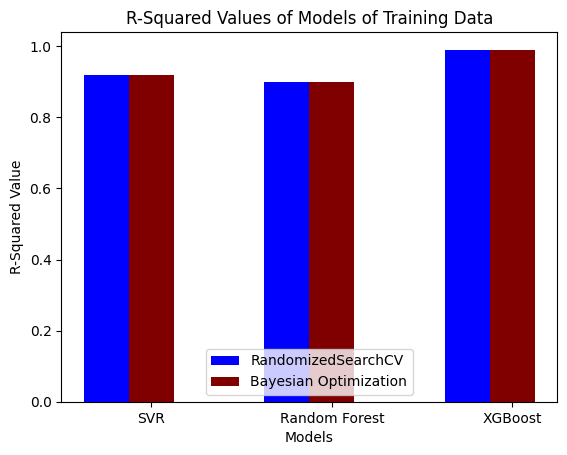

In [21]:
# Plot model r-squared values from RandomizedSearchCV and Bayesian Optimization

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(performance_rg['Model']))
br2 = [x + barWidth for x in br1]

# Plot r-squared values from RandomizedSearchCV at br1 positions
plt.bar(br1, performance_rg['Best Score (R-Squared)'],\
                                                        color = 'blue',\
        label = 'RandomizedSearchCV', width = barWidth)

# Plot r-squared values from Bayes Optimization at br2 positions
plt.bar(br2, performance_bo_['Best Score (R-Squared)'],\
                                                        color = 'maroon',\
        label = "Bayesian Optimization", width = barWidth)

# Label model xlabel, y, label, title, and tickmarks
plt.xlabel("Models")
plt.ylabel("R-Squared Value")
plt.title("R-Squared Values of Models of Training Data")
plt.xticks([r + barWidth for r in range(len(performance_rg['Model']))],
        ['SVR', 'Random Forest', 'XGBoost'])

# Show legend
plt.legend()
plt.show()

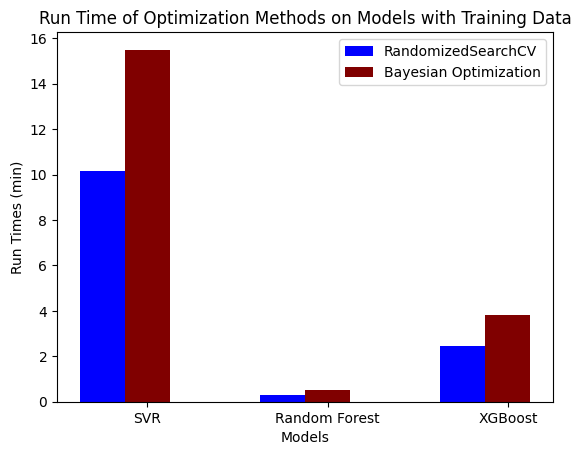

In [22]:
# Plot RandomizedSearchCV and Bayesian Optimization run times for each model

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(performance_rg['Model']))
br2 = [x + barWidth for x in br1]

# Plot run times from RandomizedSearchCV at br1 positions
plt.bar(br1, performance_rg['Optimization Time (min)'],\
                                                        color = 'blue',\
        label = 'RandomizedSearchCV', width = barWidth)

# Plot run times from Bayes Optimization at br2 positions
plt.bar(br2, performance_bo_['Optimization Time (min)'],\
                                                        color = 'maroon',\
        label = "Bayesian Optimization", width = barWidth)

# Label model xlabel, y, label, title, and tickmarks
plt.xlabel("Models")
plt.ylabel("Run Times (min)")
plt.title("Run Time of Optimization Methods on Models with Training Data")
plt.xticks([r + barWidth for r in range(len(performance_rg['Model']))],
        ['SVR', 'Random Forest', 'XGBoost'])

# Show legend
plt.legend()
plt.show()

##Model Comparison
XGBoost performed the best based on R-Squared values when using models oiptimized with RandomizedSearchCV and Bayesian Optimization. Support Vector Regression performed the second best, and Random Forest Regression performed the worst out of the 3 algorithms. This may be due to not exploring the correct parameter space. Future work should look into greater exploration of the Random Forest Regressor hyperparameter space using Bayes Optimization.

## Hyperparameter Tuning
RandomizedSearchCV and Bayesian Optmization methods found best model hyperparameters which gave similar performance scores. However, RandomizedSearchCV's run time for optimization was lower than Bayes Optmization for this set of hyperparameters. When looking at a broader hyperparameter space, Bayesian Optmization may outperformn RandomizedSearchCV.

We will use XGBoost to predict test data and evaluate performance, using model parameters found using Bayes Optimization.

In [23]:
# Initiate XGB regressor
XGBreg = XGBRegressor(learning_rate = 0.0517, max_depth = 8 , min_child_weight = 1.5597, subsample = 0.7719)

# Fit model to trainign data
XGBreg.fit(X_train, y_train)

# Predict model
y_pred = XGBreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [24]:
print('Mean absolute error: ', round(mae,2))
print('R-squared value: ', round(r2, 2))

Mean absolute error:  2.49
R-squared value:  0.99


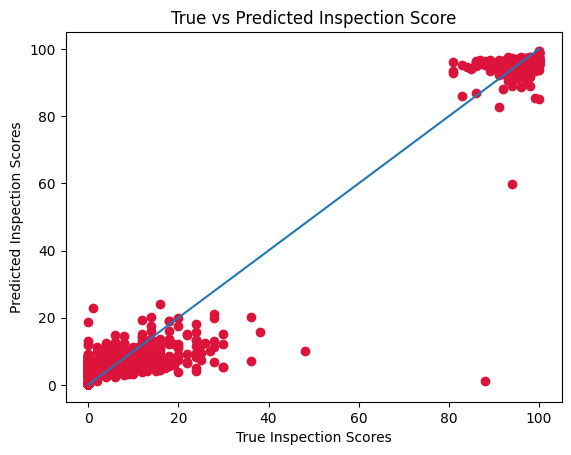

In [25]:
# Create scatter plot of Predicted vs True Inspection Scores
plt.scatter(y_test, y_pred, c = 'crimson')

# Plot y = x line
plt.plot([0, 100], [0,100])

# Add axes labels and title
plt.ylabel('Predicted Inspection Scores')
plt.xlabel('True Inspection Scores')
plt.title('True vs Predicted Inspection Score')
plt.show()

Text(0.5, 1.0, 'Residual Plot')

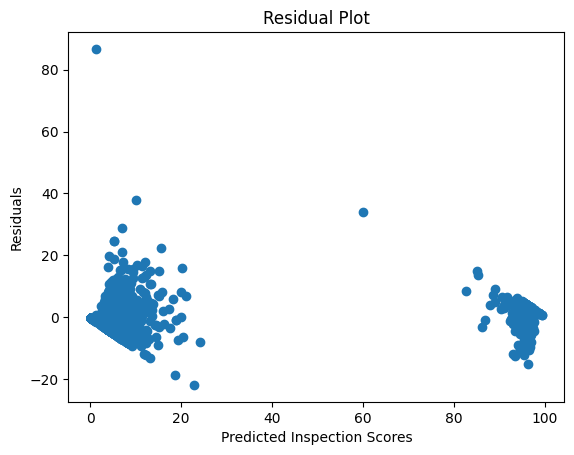

In [26]:
# Plot residuals

# Create a dataframe from y_pred values
y_pred_df = pd.DataFrame(y_pred, columns=["predicted_score"])

# Calculate residuals
residuals = pd.DataFrame()
residuals['residuals'] = y_test['score_sum'] - y_pred_df['predicted_score']

# Plot a scatter plot of residuals
plt.scatter(y_pred_df['predicted_score'], residuals['residuals'])

# Add axes labels and title
plt.xlabel('Predicted Inspection Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot')

In [27]:
# Import column names
col_names = pd.read_csv('/content/col_names.csv')
col_names = col_names.drop(['Unnamed: 0'], axis = 1)

In [28]:
# Determine the 10 top contributing features to model

# Store XGBoost model importances in 'importances
importances = XGBreg.feature_importances_

# Create a dataframe of importances
importances_df =pd.DataFrame(importances, columns = ['Importances'])

# Add a column which includes names of the features
importances_df['Features'] = col_names

# Sort the dataframe by importances of features
importances_df = importances_df.sort_values(by = 'Importances', ascending = False)

# Slide the top 10 features to be ploted
importances_plot = importances_df.iloc[0:10,:]

# Print out the top 10 features
importances_plot

,Importances,Features
2,0.835015,rpt_area_code
14,0.055758,D_V - VISIT
13,0.041950,D_S - STATUS CHANGE
11,0.006431,D_CVV - CRITICAL VIOLATION VISIT
64,0.005160,TFIDF_closed
31,0.004337,D_Tattoo Establishments
7,0.001823,permit_status_id
0,0.001778,sewage
1,0.001648,water
5,0.001535,est_num


<Axes: xlabel='Importances', ylabel='Features'>

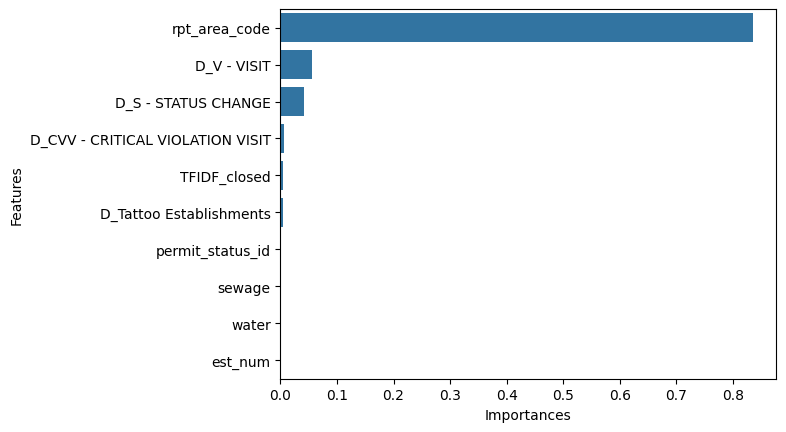

In [29]:
# Plot important features for regression in XGBoost
sns.barplot(x = importances_plot.Importances, y = importances_plot.Features,\
            orient = 'h')

**## Conclusion**

The best XGBoost parameters were used in fitting the full training data set. It resulted in R-Square value of 0.99 and mean absolute value of 2.49. It performed similarly to the training data.  However, we see there is a large gap in scores from 30 - 80. Future analysis should check for a full data set that includes the full range of inspection scores using a historgram. The model seems to underestimate and overestimate the true inspection score. As the true score comes close to the 30 - 80 score gap, the model's error gets larger. This might be due to the lack of data in this region of the score distribution. This is also evident in the residual plot where we observe that the residuals fan out as the true inspection scores come closer to the 30 - 80 score gap.

The area code has a score of 0.835 for importance to the model. The next few features that are of importance are the reason for the inspection, the the type of establishment (tattooo), then the water, and sewage used.

 There were also a few outliers which should be investigated as they have a much higher true score than predicted. It would be good to test a similar approach to building a regression set for a dataset with inspection scores that cover the full range.
